# Régression logistique et convexité

La régression logistique est un modèle de classification binaire, simple à interpréter mais limité dans la gamme des problèmes qu'il peut résoudre. Limité comment ?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Un jeu de données

Non convexe.

In [3]:
from sklearn.datasets import make_blobs
X, labels_true = make_blobs(n_samples=750, centers=6, cluster_std=0.4)
labels_true = labels_true % 3

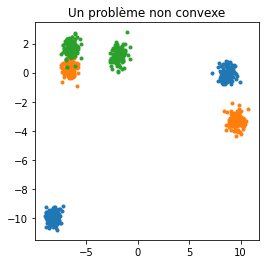

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i in range(max(labels_true) + 1):
    ax.plot(X[labels_true==i, 0], X[labels_true==i, 1], '.', label='c%d' % i)
ax.set_title("Un problème non convexe");

## Deux modèles

Comparons une régression logistique avec un arbre de décision.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
log = LogisticRegression()
dec = DecisionTreeClassifier(max_depth=3)
log.fit(X, labels_true)
dec.fit(X, labels_true)
log.score(X, labels_true), dec.score(X, labels_true)

(0.6226666666666667, 0.812)

L'arbre de décision est beaucoup plus performant.

In [6]:
from sklearn.tree import export_graphviz
from jyquickhelper import RenderJsDot
dot = export_graphviz(dec, out_file=None)
RenderJsDot(dot)

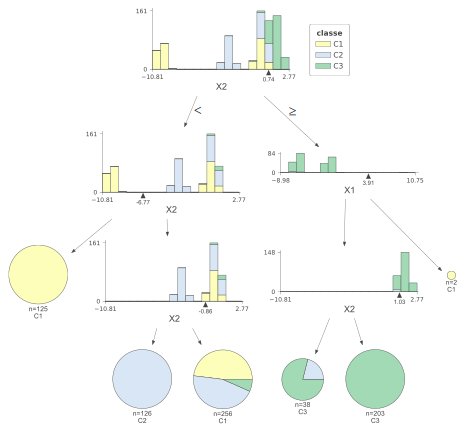

In [7]:
from dtreeviz.trees import dtreeviz
from IPython.display import SVG

viz = dtreeviz(dec, X, labels_true, target_name='classe',
               feature_names=['X1', 'X2'], class_names=["C1", "C2", "C3"])  

SVG(viz.svg())

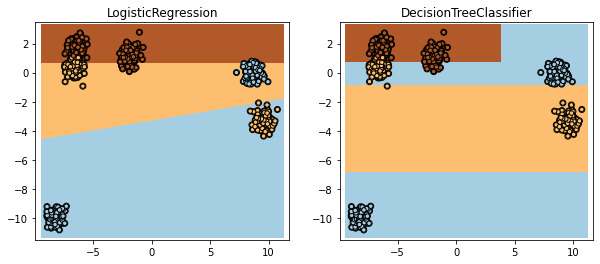

In [8]:
import numpy

def plot_horizontal_classifiers2D(classifiers):
    fig, ax = plt.subplots(1, len(classifiers), figsize=(5 * len(classifiers), 4))
    h = .02
    for i, model in enumerate(classifiers):

        ax[i].scatter(X[:, 0], X[:, 1], c=labels_true, zorder=10,
                      cmap=plt.cm.Paired, edgecolor='k', s=20)

        ax[i].axis('tight')

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                                numpy.arange(y_min, y_max, h))
        Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax[i].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

        # Plot also the training points
        ax[i].scatter(X[:, 0], X[:, 1], c=labels_true, edgecolors='k', cmap=plt.cm.Paired)

        ax[i].set_title(str(model).split('(')[0])
    return ax


plot_horizontal_classifiers2D([log, dec]);

La régression logistique est clairement moins performante mais pour la défendre, elle ne peut représenter qu'une partition convexe de l'espace des features. Autrement dit, si les classes à apprendre ne sont pas convexes, la régression logistique ne peut pas les modéliser. Deux options alors : soit changer pour un autre modèle non linéaire, soit ajouter des variables de telles sortes dans l'espace des features étendues, ce problèmes deviennent un problème de classes convexe.

## Utilisation des k-means

Et si on appliquait un [k-means](https://fr.wikipedia.org/wiki/K-moyennes) sur chacune des classes... C'est comme si on divisait chacune des classes en petits bouts convexes. Voyons jusqu'ou cela nous mène... Cette variante est implémentée en un seul modèle dans le module [mlinsights](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/index.html) et illustrée dans le notebook [LogisticRegression and Clustering](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/notebooks/logistic_regression_clustering.html).

In [9]:
from mlinsights.mlmodel import ClassifierAfterKMeans
clcl = ClassifierAfterKMeans(e_max_iter=1000)
clcl.fit(X, labels_true)

ClassifierAfterKMeans(c_algorithm='auto', c_copy_x=True,
    c_init='k-means++', c_max_iter=300, c_n_clusters=2, c_n_init=10,
    c_n_jobs='deprecated', c_precompute_distances='deprecated',
    c_random_state=None, c_tol=0.0001, c_verbose=0, e_C=1.0,
    e_class_weight=None, e_dual=False, e_fit_intercept=True,
    e_intercept_scaling=1, e_l1_ratio=None, e_max_iter=1000,
    e_multi_class='auto', e_n_jobs=None, e_penalty='l2',
    e_random_state=None, e_solver='lbfgs', e_tol=0.0001, e_verbose=0,
    e_warm_start=False)

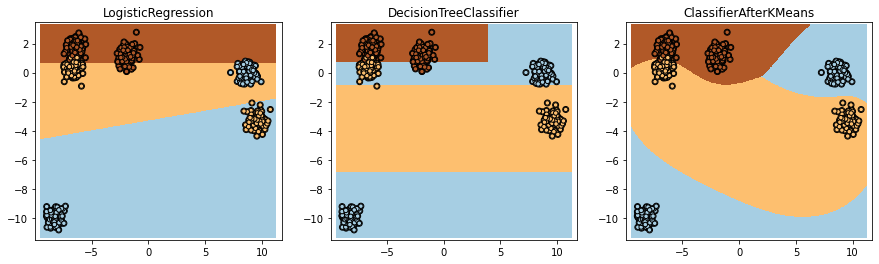

In [10]:
plot_horizontal_classifiers2D([log, dec, clcl]);

Chaque classe a été coupée en deux. Les frontières ne sont plus linéaires car la régression logistique opère sur les distances aux clusters et non sur les variables elles-mêmes. Le code relatif à l'apprentissage est ici : [ClassifierAfterKMeans.fit](https://github.com/sdpython/mlinsights/blob/master/mlinsights/mlmodel/classification_kmeans.py#L43).